# QIP Application - ME22B111
This is my app for the QIP project, I have built a price predictive model, then analysed the feasibility of HFT using aggregrate trades data then used various indicators and tools to identify trends and market variations to then create trade signals and generate P&L using these.

## Price Prediction ML Model

The following is a price predictive ML model that uses a Random Forest Algorithm to determine the future price for the given data. I have used the python libraries ta for various technical analysis tools, scikit for my ML model and seaborn for visualising various attributes.


I begin by importing all necessary libraries for the analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy import stats
from ta import add_all_ta_features


Loading the given datasets for OHLC data and Aggregate trades data

In [2]:
# Load OHLC candlestick data
ohlc_data = pd.read_csv('BTCUSDT-1m-2023-11.csv')
# Load Aggregated Trades data
trades_data = pd.read_csv('BTCUSDT-aggTrades-2023-11.csv')

In [3]:
#Converting UNIX time to human time
ohlc_data['open_time'] = pd.to_datetime(ohlc_data['open_time'], unit='ms')
ohlc_data

,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume,ignore
0,2023-11-01 00:00:00,34651.4,34676.5,34650.0,34669.9,376.040,1698796859999,1.303610e+07,4214,199.885,6.929501e+06,0
1,2023-11-01 00:01:00,34669.9,34684.0,34637.3,34637.4,431.177,1698796919999,1.494828e+07,4495,229.490,7.957308e+06,0
2,2023-11-01 00:02:00,34637.4,34653.4,34632.5,34651.4,175.894,1698796979999,6.093655e+06,2669,71.494,2.476893e+06,0
3,2023-11-01 00:03:00,34651.3,34651.4,34608.6,34621.1,476.587,1698797039999,1.650097e+07,5182,89.613,3.102759e+06,0
4,2023-11-01 00:04:00,34621.1,34622.6,34592.0,34615.4,546.312,1698797099999,1.890390e+07,5557,214.962,7.438203e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...
43195,2023-11-30 23:55:00,37699.9,37701.9,37698.6,37698.6,29.083,1701388559999,1.096435e+06,379,21.770,8.207305e+05,0
43196,2023-11-30 23:56:00,37698.6,37698.7,37696.0,37696.1,6.072,1701388619999,2.288919e+05,243,3.875,1.460724e+05,0
43197,2023-11-30 23:57:00,37696.0,37696.1,37691.8,37691.9,24.287,1701388679999,9.154649e+05,431,7.510,2.830785e+05,0
43198,2023-11-30 23:58:00,37691.9,37697.8,37691.8,37697.8,20.963,1701388739999,7.901872e+05,350,17.426,6.568599e+05,0


Using ta library to add all of it's feautures to my ohlc_data dataframe

In [4]:
ohlc_data = add_all_ta_features(ohlc_data, open='open', high='high',low='low', close='close', volume='volume', fillna="True")

### ML Model 
The model have 2 parts - a classifier and a regressor. I used the classifier model mostly for testing as it provides a bullish/bearish output with no sense of magnitude. The regressor is used for price prediction and then generating P&L report.
The feautures used for the model are the following:
 * OHLC values : Basic open price, close price, high value and low value.
 * Simple Moving Average : I'm using 2 SMAs, one with a short window(sma_fast) and the other with a long window(sma_slow). This is used as a price trend indicator.
 * Relative Strength Index : RSI is an indicator based on volume momentum oscillator used to indicate whether the underlying is overbought or oversold.
 * Bollinger Bands : They are a volatilty indicator used to track the standard deviation along with the sma of the underlying.
 * Keltner Channels : This is a volatility indicattor similar to Bollinger bands but uses ATR (Average True Range) along with EMA(Exponenetial Moving Range) to create a band with 3 lines - a center line with EMA and upper and lower lines with EMA +/- 2*ATR

We then define the target values for the classifier and regressor, which is the close price of the next trading session (next 1m candle)

In [5]:
#Declaring feature and target variables for the model to work on
features = ohlc_data[['open', 'high', 'low', 'close', 'volume', 'trend_sma_fast', 'trend_sma_slow',
               'momentum_rsi', 'trend_macd', 'volatility_bbm',
               'volatility_bbw', 'volatility_kcc', 'volatility_kch', 'volatility_kcl']]
ohlc_data['Price_Up'] = np.where(ohlc_data['close'].shift(-1) > ohlc_data['close'], 1, 0)
target = ohlc_data['Price_Up']
target_classification = ohlc_data['Price_Up']
target_regression = ohlc_data['close'].shift(-1)
target_regression = target_regression.fillna(method='ffill')

features

/tmp/ipykernel_551/1669938927.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  target_regression = target_regression.fillna(method='ffill')


,open,high,low,close,volume,trend_sma_fast,trend_sma_slow,momentum_rsi,trend_macd,volatility_bbm,volatility_bbw,volatility_kcc,volatility_kch,volatility_kcl
0,34651.4,34676.5,34650.0,34669.9,376.040,34669.900000,34669.900000,100.000000,0.000000,34669.900,0.000000,34665.466667,34691.966667,34638.966667
1,34669.9,34684.0,34637.3,34637.4,431.177,34653.650000,34653.650000,0.000000,-2.592593,34653.650,0.187570,34659.183333,34695.783333,34622.583333
2,34637.4,34653.4,34632.5,34651.4,175.894,34652.900000,34652.900000,31.689572,-3.477472,34652.900,0.153643,34654.711111,34686.077778,34623.344444
3,34651.3,34651.4,34608.6,34621.1,476.587,34644.950000,34644.950000,18.226950,-6.548218,34644.950,0.207335,34647.791667,34682.016667,34613.566667
4,34621.1,34622.6,34592.0,34615.4,546.312,34639.040000,34639.040000,16.782548,-9.334150,34639.040,0.230288,34640.233333,34673.733333,34606.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43195,37699.9,37701.9,37698.6,37698.6,29.083,37703.875000,37703.973077,49.811063,2.910565,37702.960,0.087943,37703.966667,37712.056667,37695.876667
43196,37698.6,37698.7,37696.0,37696.1,6.072,37702.966667,37703.584615,48.418741,2.217955,37702.915,0.088310,37703.856667,37711.166667,37696.546667
43197,37696.0,37696.1,37691.8,37691.9,24.287,37701.875000,37702.811538,46.087991,1.314994,37703.020,0.086673,37703.383333,37710.513333,37696.253333
43198,37691.9,37697.8,37691.8,37697.8,20.963,37702.141667,37702.238462,49.747534,1.063215,37703.155,0.085501,37701.990000,37707.810000,37696.170000


The following is a correlation heat mao between the features used and my target variables. I used this to analyse the correlation between the feautures amongst themselves to help the model make a more accurate prediction.

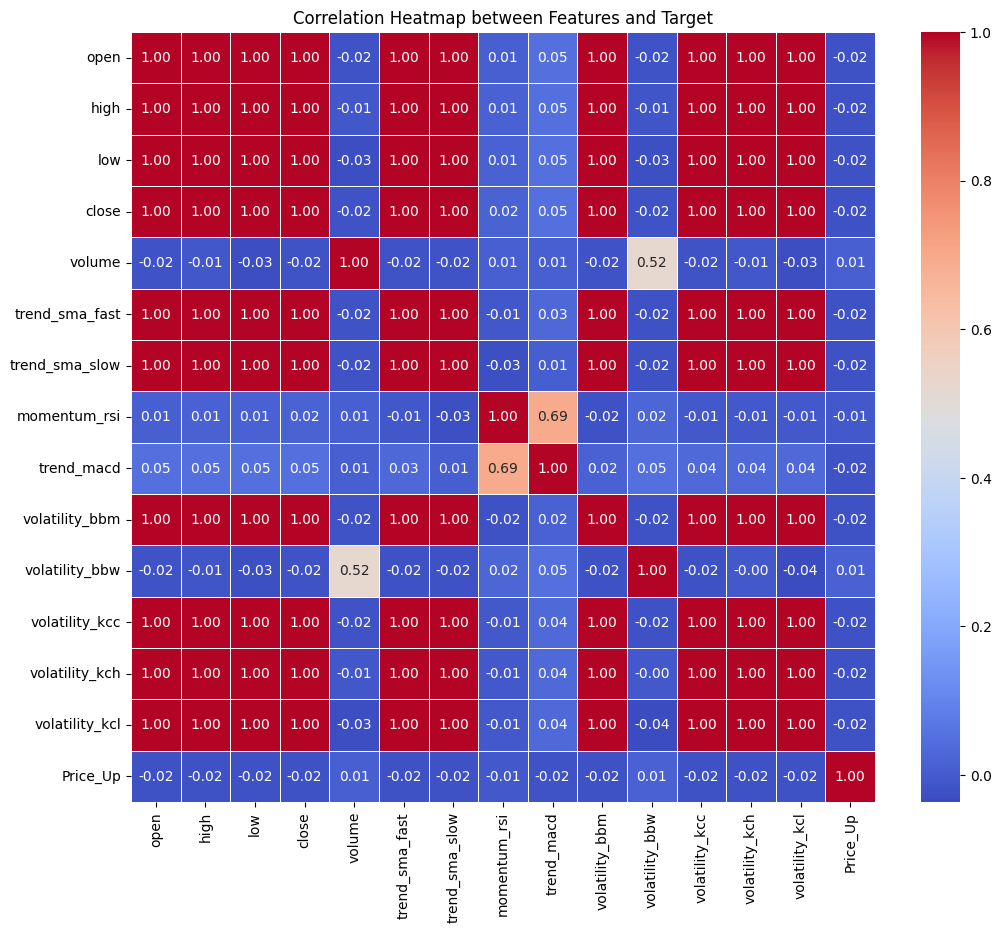

In [6]:
# Concatenate features and target into a single DataFrame
data_for_heatmap = pd.concat([features, target], axis=1)

# Compute the correlation matrix
correlation_matrix = data_for_heatmap.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap between Features and Target')
plt.show()

I have split the data for training and testing of the model with 80% of the data allocated for training and then used a standard scaler to scale the input
data for bette processing by the model

In [7]:
# Split the data into training and testing sets for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(features, target_regression, test_size=0.2, random_state=42)

# Split the data into training and testing sets for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(features, target_classification, test_size=0.2, random_state=42)

# Standardize the features for regression
scaler_reg = StandardScaler()
X_train_scaled_reg = scaler_reg.fit_transform(X_train_reg)
X_test_scaled_reg = scaler_reg.transform(X_test_reg)

# Standardize the features for classification
scaler_class = StandardScaler()
X_train_scaled_class = scaler_class.fit_transform(X_train_class)
X_test_scaled_class = scaler_class.transform(X_test_class)

Here I am implementing a Random Forest Classifier Model to do price prediction using regression. Random Forest Algorithm for ML is a supervised learning model that uses decision trees and averages their result. This results in an accurate model for large data sets with the only downside being a longer runtime. Decision trees on their own when they become deep start overfitting data and give results with very low bias but high variance, this is eliminated by taking the average ie.Average of all the trees in the "Forest".
The basic working of a Random Forest Classifier is as follows:
 * Select random samples from a given data or training set and create decision trees at those points and begin.
 * The decision trees are constructed for each point and a result is drawn from them.
 * A process called Ensemble is used here where multiple models(trees) are used to get a more accurate ouput.
 * In Random Forest Algorithm, Ensemble is done by the Bagging method-majority voting by taking average of all results.
 * The final output is the average output of all the decision trees.
 * Other models like XGBoost use Ensemble by boosting, this uses the output of one model(tree) to boost the result accuracy of other models(trees).

The hyperparameters for this model are the following:
 * n_estimators : The number of decision trees made by the Random Forest Algorithm, it can be used to increase the predictive accuracy of the model.
 * random_state : Controls randomness of the sample. The model will always produce the same results if it has a definite value of random state and if it has been given the same hyperparameters and the same training data. This is used to increase the speed of the model.

In [8]:
# Initialize Random Forest Regressor for price prediction
model_reg = RandomForestRegressor(n_estimators=200, random_state=42)
model_reg.fit(X_train_scaled_reg, y_train_reg)

# Initialize Random Forest Classifier for price movement prediction
model_class = RandomForestClassifier(n_estimators=100, random_state=42)
model_class.fit(X_train_scaled_class, y_train_class)

# Make predictions for regression
predictions_reg = model_reg.predict(X_test_scaled_reg)

# Make predictions for classification
predictions_class = model_class.predict(X_test_scaled_class)


In [9]:

# Evaluate the regression model
mse = mean_squared_error(y_test_reg, predictions_reg)
print(f'Mean Squared Error (Regression): {mse:.2f}')
r2 = r2_score(y_test_reg, predictions_reg)
print(f"R-squared (R2): {r2}")

# Evaluate the classification model
accuracy = accuracy_score(y_test_class, predictions_class)
print(f'Accuracy (Classification): {accuracy:.2f}')


Mean Squared Error (Regression): 509.75
R-squared (R2): 0.9995663737555912
Accuracy (Classification): 0.53


The following is the plot for the actual v/s the predicted values by the regression model.

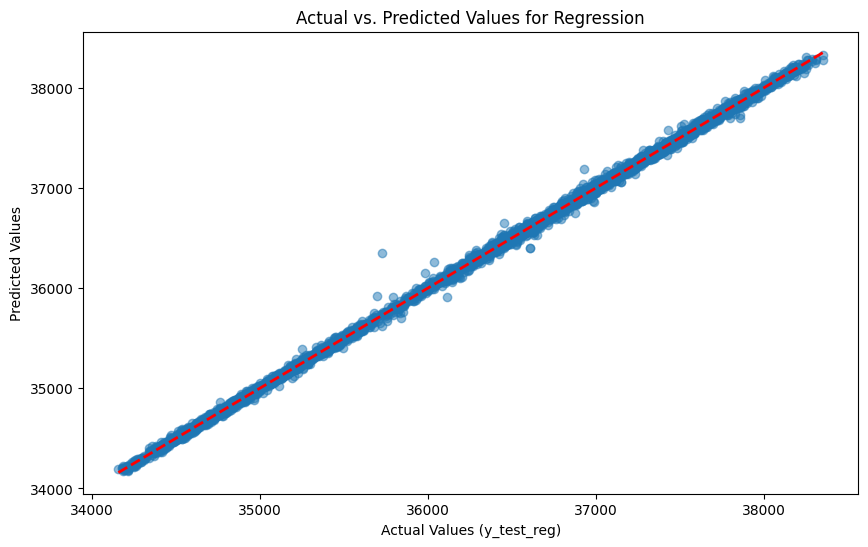

In [10]:
# Plotting actual vs. predicted values for regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, predictions_reg, alpha=0.5)
plt.plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], linestyle='--', color='red', linewidth=2)
plt.title('Actual vs. Predicted Values for Regression')
plt.xlabel('Actual Values (y_test_reg)')
plt.ylabel('Predicted Values')
plt.show()

# Trend Indicators

### RSI
The relative strength index (RSI) is a momentum indicator used in technical analysis. RSI measures the speed and magnitude of an underlying's recent price changes to evaluate overvalued or undervalued conditions. It can also indicate securities that may be primed for a trend reversal or corrective pullback in price. It can signal when to buy and sell. Traditionally, an RSI < 30 indicates an oversold condition and RSI>70 indicates an overbought situation. 

RSI is calculated using the average gain and the average loss over trading sessions. The formula is as follows:
\begin{equation}
    RSI = 100 - \frac{100}{1 + RS}
\end{equation}

where \( RS \) is the relative strength, given by:

\begin{equation}
    RS = \frac{\text{Average Gain}}{\text{Average Loss}}
\end{equation}

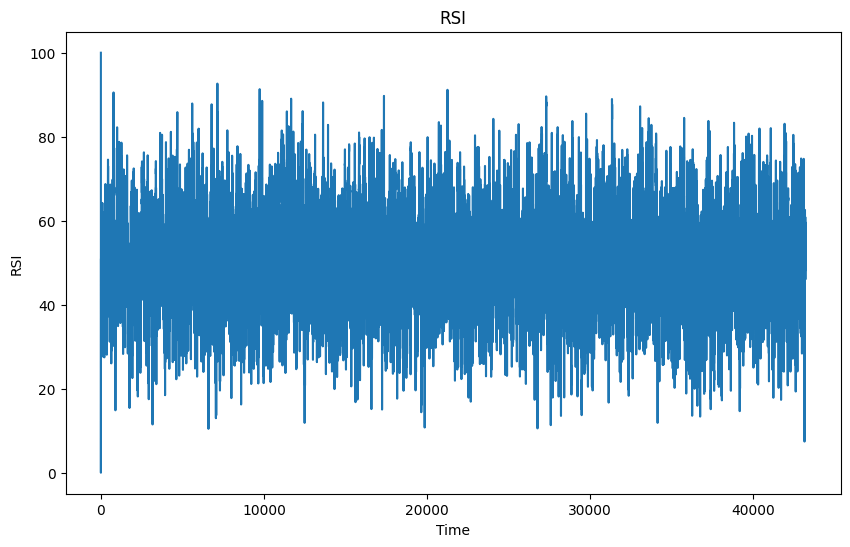

In [11]:
#Plotting RSI v/s time
plt.figure(figsize=(10, 6))
plt.plot(ohlc_data['momentum_rsi'])
plt.title('RSI')
plt.xlabel('Time')
plt.ylabel('RSI')
plt.show()

This creates buy/sell signals from the rsi data. I have implemented a strategy where buy signal is True when RSI>60 and a sell signal is True when RSI<40. This naturally also results in a Neutral signal(not explicitly defined) whenever the 40<=RSI<=60

In [12]:
# Defining RSI trading signals
ohlc_data['buy_signal_rsi'] = np.where(ohlc_data['momentum_rsi'] < 40.0, 1, 0)
ohlc_data['sell_signal_rsi'] = np.where(ohlc_data['momentum_rsi'] > 60.0, 1, 0)


### Simple Moving Average and SMA Crossover Strategy
A simple moving average (SMA) calculates the average of a selected range of prices, by the number of periods in that range. It is the arithmetic moving average calculated by adding recent prices within a defined period and then dividing that figure by the number of time periods in the calculation average.
It is used to identify various price trends of a security. It is calculated as the following:
\begin{equation}
    SMA = \frac{1}{n} \sum_{i=1}^{n} P_i
\end{equation}

where \( n \) is the size of the specified time period, and \( P_i \) represents the individual prices.


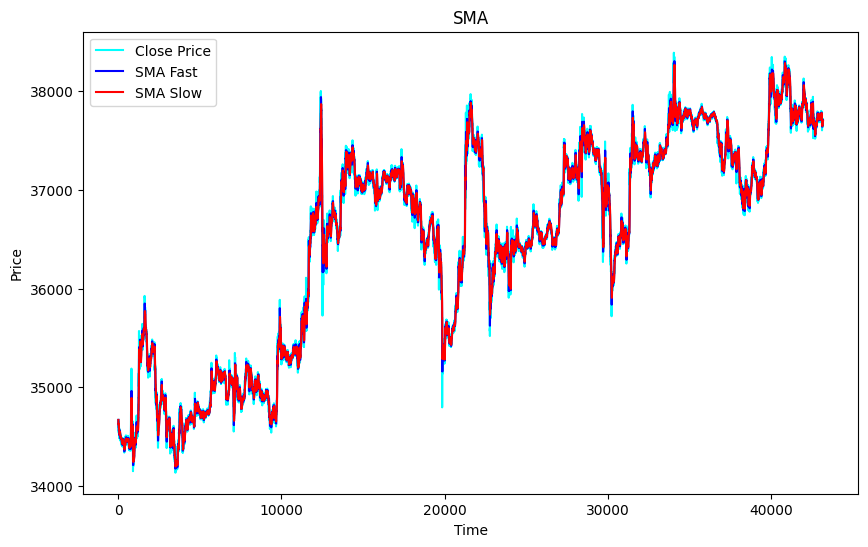

In [13]:
#Plotting SMA fast and SMA slow v/s time 
plt.figure(figsize=(10, 6))
plt.plot(ohlc_data['close'], color='cyan', label='Close Price')
plt.plot(ohlc_data['trend_sma_fast'], color='blue', label='SMA Fast')
plt.plot(ohlc_data['trend_sma_slow'], color='red', label='SMA Slow')
plt.legend()
plt.title('SMA')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

I have used a simple SMA Crossover strategy where I use 2 SMAs with different time periods, an sma_fast and an sma_slow. Whenever the sma_fast crosses below the sma_slow a sell signal is turned on and whenever it is above a buy signal is initiated. This is loosely inspired from the death cross which is when the 50 day sma crosses below the 200 day sma sharpely indicating strong bear pressure and the golden cross which is the opposite of this when 50d sma crosses above 200d sma sharpely indicating strong bull pressure

In [14]:
# Create a buy signal when sma_fast crosses above sma_slow
ohlc_data['buy_signal_sma'] = np.where(ohlc_data['trend_sma_fast'] > ohlc_data['trend_sma_slow'], 1, 0)

# Create a sell signal when sma_fast crosses below sma_slow
ohlc_data['sell_signal_sma'] = np.where(ohlc_data['trend_sma_fast'] < ohlc_data['trend_sma_slow'], 1, 0)

### Bollinger Bands
They are a set of trendlines used for technical analysis. It composes of 3 lines-a moving average line and 2 lines above and below which are moving average +/- standard deviation. This is a good way to gauge the volatility of a security using the concept of "squeeze", which is when the bollinger bands width decreases, thus indicating a period of lower volatility. Generally the closer the price is to the upper band, the more overbought the security is considered and the closer to it's lower band the more oversold it is considered, this is not always the case as large volume action can cause changes in the width of the band (volatility) itself leading to wrong indication. Thus it is generally used in combination with other indicators such as RSI, MACD, etc.

Bollinger Bands are computed as follows:

\begin{equation}
    \text{Middle Band (SMA)} = \frac{1}{N} \sum_{i=1}^{N} TP_i
\end{equation}

\begin{equation}
    \text{Upper Band} = \text{SMA} + k \times \sigma
\end{equation}

\begin{equation}
    \text{Lower Band} = \text{SMA} - k \times \sigma
\end{equation}

where:
\begin{align*}
    &N \text{ is the number of periods for the moving average}, \\
    &TP_i \text{ the Typical Price is calculated as } TP_i = \frac{\text{open} + \text{close} + \text{high}}{3}, \\
    &k \text{ is a multiplier to determine the band width}, \\
    &\sigma \text{ is the standard deviation of the data points.}
\end{align*}

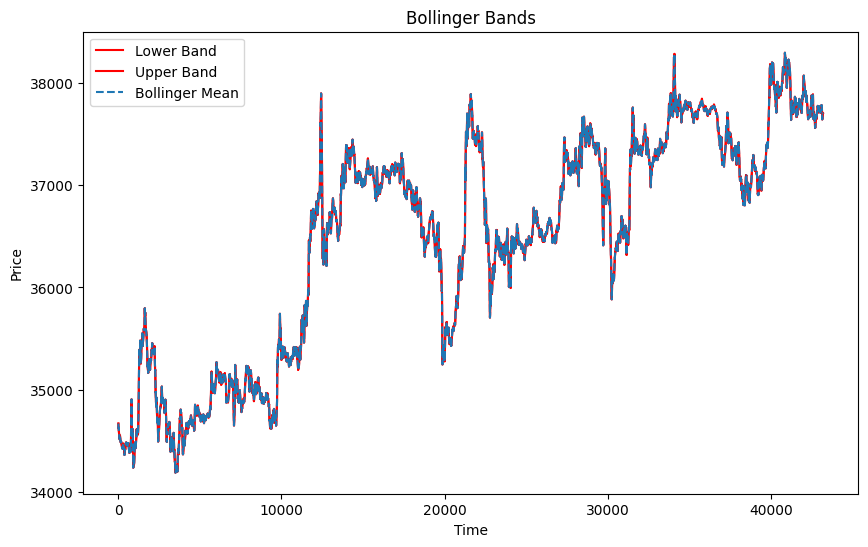

In [15]:
plt.figure(figsize=(10, 6))
# Calculating upper and lower bollinger bands using the precalculated bollinger band mean and the bollinger band width
plt.plot((ohlc_data['volatility_bbm']-ohlc_data['volatility_bbw']), color='red', label = 'Lower Band')
plt.plot((ohlc_data['volatility_bbm']+ohlc_data['volatility_bbw']), color='red', label = 'Upper Band')
plt.plot(ohlc_data['volatility_bbm'], label='Bollinger Mean', linestyle = 'dashed')
plt.legend()
plt.title('Bollinger Bands')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

I am using a bollinger band strategy that involves creating but/sell signals. As the bollinger bands are built on standard deviation, 95% of all price action occurs in between the bands itself.Whenever the price exits the band it indicates a large shift in volatility and thus an impending price movement
This is implemented to create a buy signal whenever the price moves below the lower bollinger line and a sell signal whenever price rises above the upper bollinger line. There is a neutral signal also implemeneted here(not explicitly), whenever the price is between the bands.

In [16]:
# Create a buy signal when the close price crosses below the lower Bollinger Band
ohlc_data['buy_signal_bb'] = np.where(ohlc_data['close'] < ohlc_data['volatility_bbm']-ohlc_data['volatility_bbw']/2, 1, 0)

# Create a sell signal when the close price crosses above the upper Bollinger Band
ohlc_data['sell_signal_bb'] = np.where(ohlc_data['close'] > ohlc_data['volatility_bbm']+ohlc_data['volatility_bbw']/2, 1, 0)


I have taken the buy/sell signals from all 3 of my indicators and created a superset by using binary AND among them to hopefully improve the accuracy of the hft model

In [17]:
# Create overall buy_signal
ohlc_data['buy_signal'] = np.where((ohlc_data['buy_signal_rsi'] == 1) & 
                                   (ohlc_data['buy_signal_sma'] == 1) &  
                                   (ohlc_data['buy_signal_bb'] == 1), 1, 0)

# Create overall sell_signal
ohlc_data['sell_signal'] = np.where((ohlc_data['sell_signal_rsi'] == 1) & 
                                    (ohlc_data['sell_signal_sma'] == 1) & 
                                    (ohlc_data['sell_signal_bb'] == 1), 1, 0)

## Evaluation Metrics used for the HFT Models
I have implemented the following metrics to track the performace of each of the models:
 * P&L graphs
 * Sharpe Ratio
 * Drawdown
 * Margin Requirement

### Sharpe Ratio
The Sharpe ratio compares the return of an investment with its risk. The Sharpe ratio divides a portfolio's excess returns by a measure of its volatility to assess risk-adjusted performance. Excess returns are those above an industry benchmark or the risk-free rate of return. A higher Sharpe ratio is better when comparing similar portfolios. It is calculated using the following formula:

\begin{equation}
    S = \frac{R_p - R_f}{\sigma_p}
\end{equation}

where:
\begin{align*}
    &R_p \text{ is the average return of the investment or portfolio}, \\
    &R_f \text{ is the risk-free rate of return}, \\
    &\sigma_p \text{ is the standard deviation of the investment or portfolio's excess returns}.
\end{align*}


### Drawdown
A drawdown refers to how much an investment or trading account is down from the peak before it recovers back to the peak. Drawdowns are a measure of downside volatility. Drawdowns help determine an investment's financial risk. It is calculated as the following:
\begin{equation}
    \text{Drawdown} = \frac{\text{Peak Value} - \text{Trough Value}}{\text{Peak Value}}
\end{equation}

where:
\begin{align*}
    &\text{Peak Value} \text{ is the highest value of the investment/portfolio up to a certain point}, \\
    &\text{Trough Value} \text{ is the lowest value of the investment/portfolio from the peak}.
\end{align*}

### Margin Requirement
This calculates the needed margin to execute the trades done by the algorithm.

## HFT Model using RSI, SMA Crossover and Bollinger Bands

In [18]:
# Create columns to track positions and initialize with zeros
ohlc_data['position'] = 0
ohlc_data['holding'] = 0
ohlc_data['pl'] = 0
ohlc_data['pl'] = ohlc_data['pl'].astype(float)
ohlc_data['daily_return'] = 0
ohlc_data['daily_return'] = ohlc_data['daily_return'].astype(float)
# Simulate the trading strategy
for i in range(1, len(ohlc_data)):
    # Buy condition
    if ohlc_data['buy_signal'][i] == 1:
        # Buy at the current close price with available cash
        ohlc_data.at[i, 'holding'] += 1
        ohlc_data.at[i, 'position'] = 1

    # Sell condition
    elif ohlc_data['sell_signal'][i] == 1:
        # Sell all holding at the current close price
        ohlc_data.at[i, 'holding'] -= 1
        ohlc_data.at[i, 'position'] = 0

    # Calculate P&L based on the change in price
    if i > 1 :
        price_change = (ohlc_data['close'][i] - ohlc_data['close'][i-1]) / ohlc_data['close'][i-1]
        ohlc_data.at[i, 'pl'] = ohlc_data['holding'][i-1] * price_change + ohlc_data['pl'][i-1]
        ohlc_data.at[i, 'daily_return'] = ohlc_data['holding'][i-1] * price_change

/tmp/ipykernel_551/2481467048.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_data['pl'] = 0
/tmp/ipykernel_551/2481467048.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_data['daily_return'] = 0


In [19]:
# Calculate average daily return and standard deviation
avg_daily_return = ohlc_data['daily_return'].mean()
std_dev_daily_return = ohlc_data['daily_return'].std()

# Calculate annualized Sharpe ratio (assuming 252 trading days in a year)
sharpe_ratio = (avg_daily_return / std_dev_daily_return) * np.sqrt(252)
print("Sharpe Ratio:", sharpe_ratio)
# Calculate cumulative returns
ohlc_data['cumulative_return'] = (1 + ohlc_data['daily_return']).cumprod()

# Calculate drawdown
ohlc_data['drawdown'] = 1 - ohlc_data['cumulative_return'] / ohlc_data['cumulative_return'].cummax()

# Maximum drawdown
max_drawdown = ohlc_data['drawdown'].max()

print("Maximum Drawdown:", max_drawdown)

# Define margin factor (e.g., 2 for 2:1 leverage)
margin_factor = 2

# Calculate margin
ohlc_data['margin'] = ohlc_data['holding'] * ohlc_data['close'] * margin_factor

print("Max Margin:", ohlc_data['margin'].max())
# Display margin for each day
print("Margin for each day:")
print(ohlc_data['margin'])

Sharpe Ratio: -0.1093674674211567
Maximum Drawdown: 0.03990985677629644
Max Margin: 76337.8
Margin for each day:
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
43195    0.0
43196    0.0
43197    0.0
43198    0.0
43199    0.0
Name: margin, Length: 43200, dtype: float64


/tmp/ipykernel_551/2780401964.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_data['cumulative_return'] = (1 + ohlc_data['daily_return']).cumprod()
/tmp/ipykernel_551/2780401964.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_data['drawdown'] = 1 - ohlc_data['cumulative_return'] / ohlc_data['cumulative_return'].cummax()
/tmp/ipykernel_551/2780401964.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

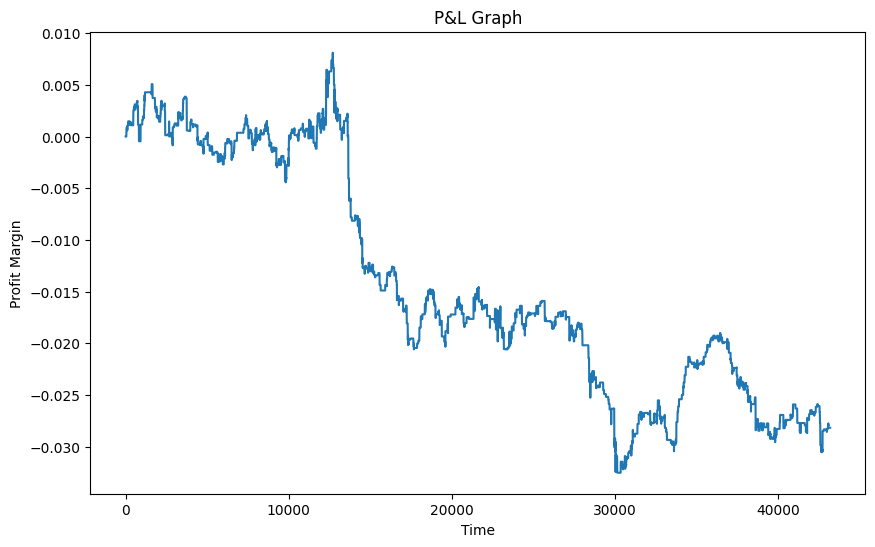

0        0.00000
1        0.00000
2        0.00000
3        0.00000
4        0.00000
          ...   
43195   -0.02817
43196   -0.02817
43197   -0.02817
43198   -0.02817
43199   -0.02817
Name: pl, Length: 43200, dtype: float64

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(ohlc_data['pl'], label='pl')
plt.title('P&L Graph')
plt.xlabel('Time')
plt.ylabel('Profit Margin')
plt.show()
ohlc_data['pl']

### Results
The above model looses 2.8% of it's starting capital. It has a Sharpe ratio of -0.1 indicating loss of capital investement. It has a max drawdown of 3.9% indicating a loss of 3.9% capital after a series of loosing trades. This model has a maximum margin requirement of 76337.8 USD.

## RSI based HFT Model

In [21]:
# Create columns to track positions and initialize with zeros
ohlc_data['position_rsi'] = 0
ohlc_data['holding_rsi'] = 0
ohlc_data['pl_rsi'] = 0
ohlc_data['pl_rsi'] = ohlc_data['pl_rsi'].astype(float)
ohlc_data['daily_return_rsi'] = 0
ohlc_data['daily_return_rsi'] = ohlc_data['daily_return_rsi'].astype(float)

# Simulate the trading strategy
for i in range(1, len(ohlc_data)):
    # Buy condition
    if ohlc_data['buy_signal_rsi'][i] == 1:
        # Buy at the current close price with available cash
        ohlc_data.at[i, 'holding_rsi'] += 1
        ohlc_data.at[i, 'position_rsi'] = 1

    # Sell condition
    elif ohlc_data['sell_signal_rsi'][i] == 1:
        # Sell all holding at the current close price
        ohlc_data.at[i, 'holding_rsi'] -= 1
        ohlc_data.at[i, 'position_rsi'] = 0

    # Calculate P&L based on the change in price
    price_change = (ohlc_data['close'][i] - ohlc_data['close'][i-1]) / ohlc_data['close'][i-1]
    ohlc_data.at[i, 'pl_rsi'] = ohlc_data['holding_rsi'][i-1] * price_change + ohlc_data['pl_rsi'][i-1]
    ohlc_data.at[i, 'daily_return_rsi'] = ohlc_data['holding_rsi'][i-1] * price_change

/tmp/ipykernel_551/2876171245.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_data['position_rsi'] = 0
/tmp/ipykernel_551/2876171245.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_data['holding_rsi'] = 0
/tmp/ipykernel_551/2876171245.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()

In [22]:
# Calculate average daily return and standard deviation
avg_daily_return_rsi = ohlc_data['daily_return_rsi'].mean()
std_dev_daily_return_rsi = ohlc_data['daily_return_rsi'].std()

# Calculate annualized Sharpe ratio (assuming 252 trading days in a year)
sharpe_ratio_rsi = (avg_daily_return_rsi / std_dev_daily_return_rsi) * np.sqrt(252)
print("Sharpe Ratio:", sharpe_ratio_rsi)
# Calculate cumulative returns
ohlc_data['cumulative_return_rsi'] = (1 + ohlc_data['daily_return_rsi']).cumprod()

# Calculate drawdown
ohlc_data['drawdown_rsi'] = 1 - ohlc_data['cumulative_return_rsi'] / ohlc_data['cumulative_return_rsi'].cummax()

# Maximum drawdown
max_drawdown_rsi = ohlc_data['drawdown_rsi'].max()

print("Maximum Drawdown:", max_drawdown_rsi)

# Define margin factor (e.g., 2 for 2:1 leverage)
margin_factor_rsi = 2

# Calculate margin
ohlc_data['margin_rsi'] = ohlc_data['holding_rsi'] * ohlc_data['close'] * margin_factor_rsi

print("Max Margin:", ohlc_data['margin_rsi'].max())
# Display margin for each day
print("Margin for each day:")
print(ohlc_data['margin_rsi'])

Sharpe Ratio: 0.11754651297158833
Maximum Drawdown: 0.03791964984048468
Max Margin: 76428.2
Margin for each day:
0            0.0
1        69274.8
2        69302.8
3        69242.2
4        69230.8
          ...   
43195        0.0
43196        0.0
43197        0.0
43198        0.0
43199        0.0
Name: margin_rsi, Length: 43200, dtype: float64


/tmp/ipykernel_551/1718417342.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_data['cumulative_return_rsi'] = (1 + ohlc_data['daily_return_rsi']).cumprod()
/tmp/ipykernel_551/1718417342.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_data['drawdown_rsi'] = 1 - ohlc_data['cumulative_return_rsi'] / ohlc_data['cumulative_return_rsi'].cummax()
/tmp/ipykernel_551/1718417342.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

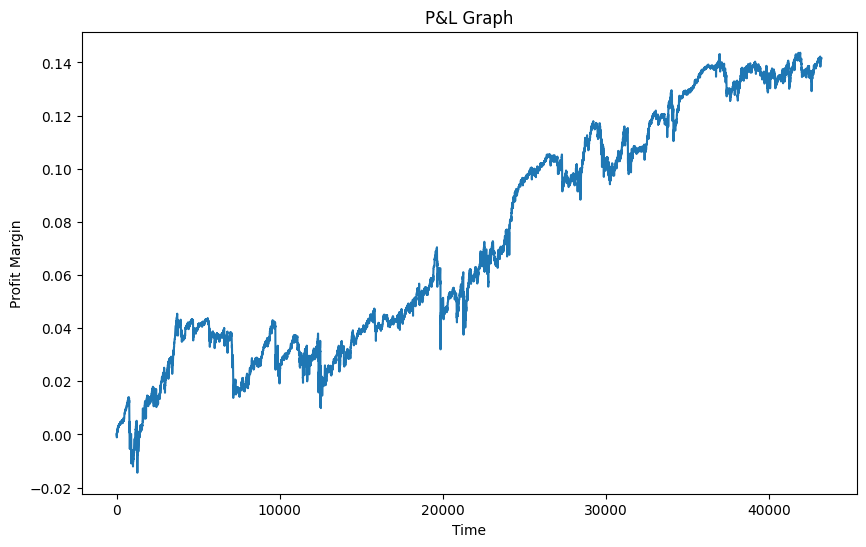

0        0.000000
1        0.000000
2        0.000404
3       -0.000470
4       -0.000635
           ...   
43195    0.141669
43196    0.141669
43197    0.141669
43198    0.141669
43199    0.141669
Name: pl_rsi, Length: 43200, dtype: float64

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(ohlc_data['pl_rsi'], label='pl_rsi')
plt.title('P&L Graph')
plt.xlabel('Time')
plt.ylabel('Profit Margin')
plt.show()
ohlc_data['pl_rsi']

### Results
The above model gains 14% of it's starting capital. It has a Sharpe ratio of 0.12 indicating gain of capital investement. It has a max drawdown of 4% indicating a loss of 4% capital after a series of loosing trades. This model has a maximum margin requirement of 76428.2 USD.

## SMA Crossover based HFT Model

In [24]:
# Create columns to track positions and initialize with zeros
ohlc_data['position_sma'] = 0
ohlc_data['holding_sma'] = 0
ohlc_data['pl_sma'] = 0
ohlc_data['pl_sma'] = ohlc_data['pl_sma'].astype(float)
ohlc_data['daily_return_sma'] = 0
ohlc_data['daily_return_sma'] = ohlc_data['daily_return_sma'].astype(float)

# Simulate the trading strategy
for i in range(1, len(ohlc_data)):
    # Buy condition
    if ohlc_data['buy_signal_sma'][i] == 1:
        # Buy at the current close price 
        ohlc_data.at[i, 'holding_sma'] += 1
        ohlc_data.at[i, 'position_sma'] = 1

    # Sell condition
    elif ohlc_data['sell_signal_sma'][i] == 1:
        # Sell 1 holding at the current close price
        ohlc_data.at[i, 'holding_sma'] -= 1
        ohlc_data.at[i, 'position_sma'] = 0

    # Calculate P&L based on the change in price
    price_change = (ohlc_data['close'][i] - ohlc_data['close'][i-1]) / ohlc_data['close'][i-1]
    ohlc_data.at[i, 'pl_sma'] = ohlc_data['holding_sma'][i-1] * price_change + ohlc_data['pl_sma'][i-1]
    ohlc_data.at[i, 'daily_return_sma'] = ohlc_data['holding_sma'][i-1] * price_change

/tmp/ipykernel_551/159490175.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_data['position_sma'] = 0
/tmp/ipykernel_551/159490175.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_data['holding_sma'] = 0
/tmp/ipykernel_551/159490175.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
 

In [25]:
# Calculate average daily return and standard deviation
avg_daily_return_sma = ohlc_data['daily_return_sma'].mean()
std_dev_daily_return_sma = ohlc_data['daily_return_sma'].std()

# Calculate annualized Sharpe ratio (assuming 252 trading days in a year)
sharpe_ratio_sma = (avg_daily_return_sma / std_dev_daily_return_sma) * np.sqrt(252)
print("Sharpe Ratio:", sharpe_ratio_sma)
# Calculate cumulative returns
ohlc_data['cumulative_return_sma'] = (1 + ohlc_data['daily_return_sma']).cumprod()

# Calculate drawdown
ohlc_data['drawdown_sma'] = 1 - ohlc_data['cumulative_return_sma'] / ohlc_data['cumulative_return_sma'].cummax()

# Maximum drawdown
max_drawdown_sma = ohlc_data['drawdown_sma'].max()

print("Maximum Drawdown:", max_drawdown_sma)

# Define margin factor (e.g., 2 for 2:1 leverage)
margin_factor_sma = 2

# Calculate margin
ohlc_data['margin_sma'] = ohlc_data['holding_sma'] * ohlc_data['close'] * margin_factor_sma

print("Max Margin:", ohlc_data['margin_sma'].max())
# Display margin for each day
print("Margin for each day:")
print(ohlc_data['margin_sma'])

Sharpe Ratio: -0.0349226974878548
Maximum Drawdown: 0.16842426027869706
Max Margin: 76780.0
Margin for each day:
0            0.0
1            0.0
2            0.0
3            0.0
4            0.0
          ...   
43195   -75397.2
43196   -75392.2
43197   -75383.8
43198   -75395.6
43199    75433.6
Name: margin_sma, Length: 43200, dtype: float64


/tmp/ipykernel_551/708886847.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_data['cumulative_return_sma'] = (1 + ohlc_data['daily_return_sma']).cumprod()
/tmp/ipykernel_551/708886847.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_data['drawdown_sma'] = 1 - ohlc_data['cumulative_return_sma'] / ohlc_data['cumulative_return_sma'].cummax()
/tmp/ipykernel_551/708886847.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfor

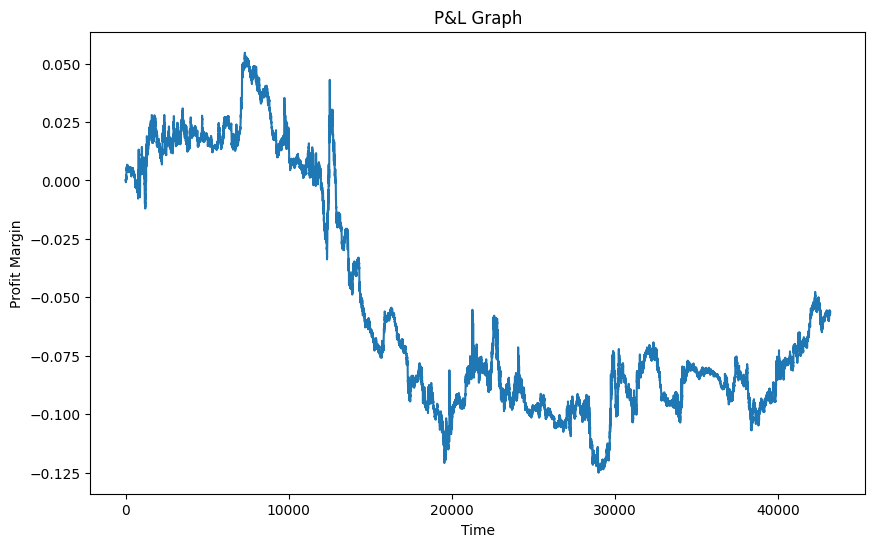

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
43195   -0.056267
43196   -0.056201
43197   -0.056089
43198   -0.056246
43199   -0.056750
Name: pl_sma, Length: 43200, dtype: float64

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(ohlc_data['pl_sma'], label='pl_sma')
plt.title('P&L Graph')
plt.xlabel('Time')
plt.ylabel('Profit Margin')
plt.show()
ohlc_data['pl_sma']

### Results
The above model looses 5.6% of it's starting capital. It has a Sharpe ratio of -0.03 indicating loss of capital investement. It has a max drawdown of 16.8% indicating a loss of 16.8% capital after a series of loosing trades. This model has a maximum margin requirement of 76780.0 USD.

## Bollinger Band based HFT Model

In [27]:
# Create columns to track positions and initialize with zeros
ohlc_data['position_bb'] = 0
ohlc_data['holding_bb'] = 0
ohlc_data['pl_bb'] = 0
ohlc_data['pl_bb'] = ohlc_data['pl_bb'].astype(float)
ohlc_data['daily_return_bb'] = 0
ohlc_data['daily_return_bb'] = ohlc_data['daily_return_bb'].astype(float)

# Simulate the trading strategy
for i in range(1, len(ohlc_data)):
    # Buy condition
    if ohlc_data['buy_signal_bb'][i] == 1:
        # Buy at the current close price 
        ohlc_data.at[i, 'holding_bb'] += 1
        ohlc_data.at[i, 'position_bb'] = 1

    # Sell condition
    elif ohlc_data['sell_signal_bb'][i] == 1:
        # Sell 1 holding at the current close price
        ohlc_data.at[i, 'holding_bb'] -= 1
        ohlc_data.at[i, 'position_bb'] = 0

    # Calculate P&L based on the change in price
    price_change = (ohlc_data['close'][i] - ohlc_data['close'][i-1]) / ohlc_data['close'][i-1]
    ohlc_data.at[i, 'pl_bb'] = ohlc_data['holding_bb'][i-1] * price_change + ohlc_data['pl_bb'][i-1]
    ohlc_data.at[i, 'daily_return_bb'] = ohlc_data['holding_bb'][i-1] * price_change

/tmp/ipykernel_551/3939641324.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_data['position_bb'] = 0
/tmp/ipykernel_551/3939641324.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_data['holding_bb'] = 0
/tmp/ipykernel_551/3939641324.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [28]:
# Calculate average daily return and standard deviation
avg_daily_return_bb = ohlc_data['daily_return_bb'].mean()
std_dev_daily_return_bb = ohlc_data['daily_return_bb'].std()

# Calculate annualized Sharpe ratio (assuming 252 trading days in a year)
sharpe_ratio_bb = (avg_daily_return_bb / std_dev_daily_return_bb) * np.sqrt(252)
print("Sharpe Ratio:", sharpe_ratio_bb)
# Calculate cumulative returns
ohlc_data['cumulative_return_bb'] = (1 + ohlc_data['daily_return_bb']).cumprod()

# Calculate drawdown
ohlc_data['drawdown_bb'] = 1 - ohlc_data['cumulative_return_bb'] / ohlc_data['cumulative_return_bb'].cummax()

# Maximum drawdown
max_drawdown_bb = ohlc_data['drawdown_bb'].max()

print("Maximum Drawdown:", max_drawdown_bb)

# Define margin factor (e.g., 2 for 2:1 leverage)
margin_factor_bb = 2

# Calculate margin
ohlc_data['margin_bb'] = ohlc_data['holding_bb'] * ohlc_data['close'] * margin_factor_bb

print("Max Margin:", ohlc_data['margin_bb'].max())
# Display margin for each day
print("Margin for each day:")
print(ohlc_data['margin_bb'])

Sharpe Ratio: -0.017392017932139427
Maximum Drawdown: 0.13314178336399052
Max Margin: 76565.8
Margin for each day:
0            0.0
1        69274.8
2        69302.8
3        69242.2
4        69230.8
          ...   
43195    75397.2
43196    75392.2
43197    75383.8
43198    75395.6
43199   -75433.6
Name: margin_bb, Length: 43200, dtype: float64


/tmp/ipykernel_551/2624518338.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_data['cumulative_return_bb'] = (1 + ohlc_data['daily_return_bb']).cumprod()
/tmp/ipykernel_551/2624518338.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_data['drawdown_bb'] = 1 - ohlc_data['cumulative_return_bb'] / ohlc_data['cumulative_return_bb'].cummax()
/tmp/ipykernel_551/2624518338.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

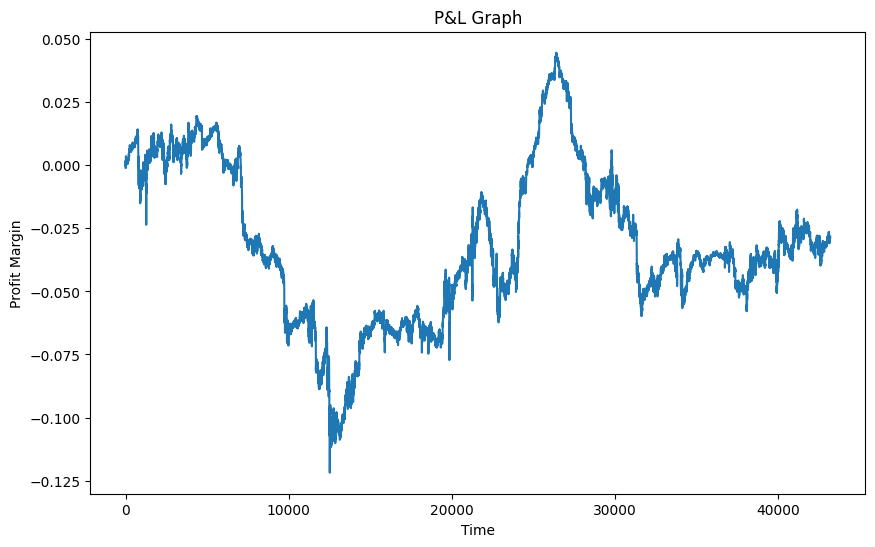

0        0.000000
1        0.000000
2        0.000404
3       -0.000470
4       -0.000635
           ...   
43195   -0.028711
43196   -0.028777
43197   -0.028889
43198   -0.028732
43199   -0.028228
Name: pl_bb, Length: 43200, dtype: float64

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(ohlc_data['pl_bb'], label='pl_bb')
plt.title('P&L Graph')
plt.xlabel('Time')
plt.ylabel('Profit Margin')
plt.show()
ohlc_data['pl_bb']

### Results
The above model looses 2.8% of it's starting capital. It has a Sharpe ratio of -0.02 indicating loss of capital investement. It has a max drawdown of 13.3% indicating a loss of 13.3% capital after a series of loosing trades. This model has a maximum margin requirement of 76565.8 USD.

# HFT Models and Analysis using Tick Bars

Traditionally time bars have been used for most applications, but there are many inherent issues with time bars such as :
 * They disguise the rate of actual activity happening in the market at any given time. This occurs due to oversampling information during periods of low volatility and undersampling during periods of high activity. This leads to a poor capture of the actual information that exists in the market and introduces a lot of extra noise for machine models to parse through.
 * Time bars have very poor statistical properties, such as non-normality. This presents an issue when attempting to fit conventional machine learning algorithms that were built upon a presupposition of various statistical patterns. In other words, time bars don’t do the best job in representing all the information and they don’t play well with machine learning models.
 * Everyone uses time bars. Unless you’re an established player that’s paying thousands of dollars for real-time or historical tick data, you’re using time bars. The big firms know this too. They can deliberately create fake volume or manipulate order books in a way that will trigger some signal like RSI or Bollinger bands because they know exactly what indicators the retail traders are looking for. When you rely on historical price data with some technical indicators thrown in to train a machine learning model, you’re not going to make money. At the end of the day, it’s garbage in, garbage out.

An alternative used to the time bar is the tick bar, A tick bar is a bar that comprises of the ohlcv data for a fixed number of transactions. I have implemented my previous strategies done on a tick bar ohlc data from the aggregrate trades data.

In [30]:
trades_data

,agg_trade_id,price,quantity,first_trade_id,last_trade_id,transact_time,is_buyer_maker
0,1900987669,34651.4,0.258,4244484021,4244484028,1698796805027,False
1,1900987670,34651.3,0.001,4244484029,4244484029,1698796805055,True
2,1900987671,34651.4,0.007,4244484030,4244484031,1698796805056,False
3,1900987672,34651.3,0.361,4244484032,4244484034,1698796805061,True
4,1900987673,34651.4,0.007,4244484035,4244484037,1698796805076,False
...,...,...,...,...,...,...,...
31204309,1932191978,37716.9,0.017,4335116117,4335116118,1701388799011,False
31204310,1932191979,37716.8,0.035,4335116119,4335116123,1701388799025,True
31204311,1932191980,37716.9,0.156,4335116124,4335116126,1701388799133,False
31204312,1932191981,37716.9,0.005,4335116127,4335116127,1701388799306,False


I am using the aggregrate trades data to generate ohlcv data for tick bars and then a basic check for normalcy of the data.

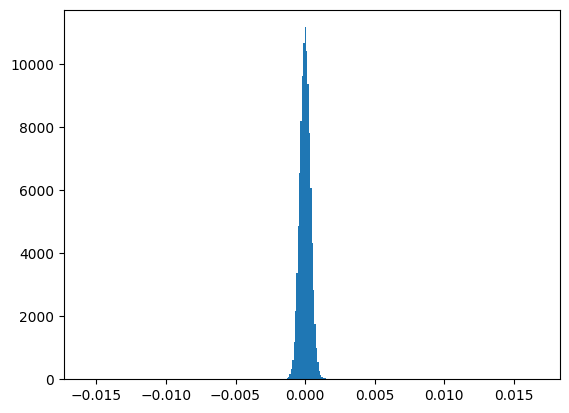

In [31]:
transactions = 300
def bar(x, y):
    return np.int64(x/y)*y
tick_bars = trades_data.groupby(bar(np.arange(len(trades_data)), transactions)).agg({'price': 'ohlc', 'quantity': 'sum'})
tick_bars_price = tick_bars.loc[:, 'price']
tick_bars_volume = tick_bars.loc[:, 'quantity']
tick_bars = np.log(tick_bars_price.close/tick_bars_price.close.shift(1)).dropna()
bin_len = 0.0001
k2, p_tick = stats.normaltest(tick_bars)
plt.hist(tick_bars, bins=np.arange(min(tick_bars),max(tick_bars)+bin_len, bin_len))
plt.show()

In [32]:
ohlc_tick = pd.concat([tick_bars_price, tick_bars_volume], axis=1)
ohlc_tick

,open,high,low,close,quantity
0,34651.4,34661.8,34651.3,34659.7,65.178
300,34659.6,34661.7,34650.0,34658.1,54.000
600,34658.2,34675.9,34658.2,34666.5,90.869
900,34666.4,34676.5,34662.4,34668.7,143.882
1200,34668.6,34681.4,34663.7,34681.4,171.770
...,...,...,...,...,...
31203000,37697.9,37700.0,37695.3,37695.4,57.925
31203300,37695.4,37701.9,37695.3,37696.1,51.938
31203600,37696.1,37697.7,37691.8,37697.7,41.439
31203900,37697.8,37704.0,37691.9,37704.0,35.376


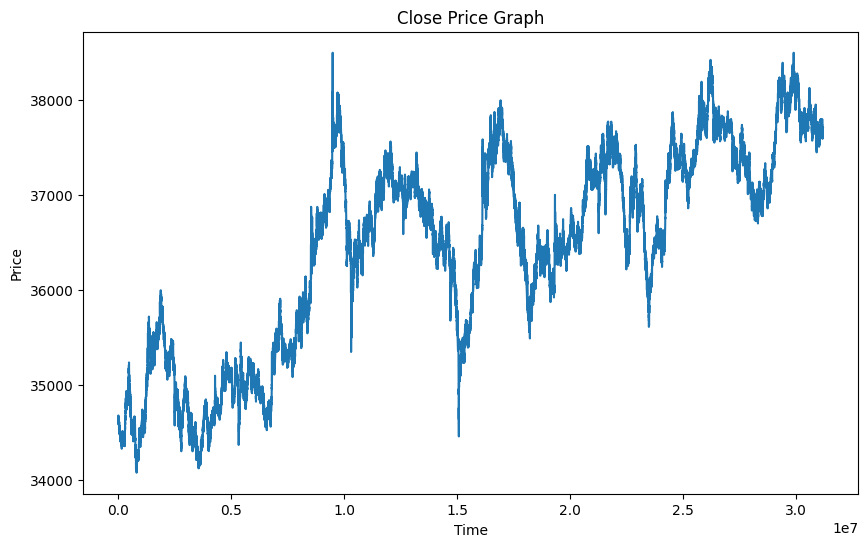

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(ohlc_tick['close'], label='Tick Bar Graph')
plt.title('Close Price Graph')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

I use ta to get all necessary indicators from my new ohlc_tick data

In [34]:
ohlc_tick = add_all_ta_features(ohlc_tick, open='open', high='high',low='low', close='close', volume='quantity', fillna="True")
ohlc_tick

,open,high,low,close,quantity,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,34651.4,34661.8,34651.3,34659.7,65.178,39.106800,65.178,0.600000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34659.700000,0.000000,0.000000,0.000000
300,34659.6,34661.7,34650.0,34658.1,54.000,59.876031,11.178,0.502408,-86.400000,-1.516667e+07,...,-0.000368,-0.000074,-0.000295,-1.385691,-0.277138,-1.108553,34658.992161,-0.004616,-0.004616,-0.004616
600,34658.2,34675.9,34658.2,34666.5,90.869,54.228805,102.047,0.258175,34.985657,2.181602e+08,...,0.001281,0.000197,0.001084,2.052296,0.188749,1.863547,34662.296238,0.024237,0.024234,0.019619
900,34666.4,34676.5,34662.4,34668.7,143.882,38.922209,245.929,0.109972,75.207763,2.351927e+07,...,0.003064,0.000771,0.002294,10.184993,2.187997,7.996996,34665.109118,0.006346,0.006346,0.025967
1200,34668.6,34681.4,34663.7,34681.4,171.770,210.692209,417.699,0.400785,376.103654,3.194388e+07,...,0.007349,0.002086,0.005263,17.828777,5.316153,12.512624,34672.074208,0.036632,0.036626,0.062609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31203000,37697.9,37700.0,37695.3,37695.4,57.925,3047.156172,25088.567,0.077616,-125.462879,-9.209322e+07,...,0.019751,0.025976,-0.006225,-8.385862,-12.323175,3.937313,37693.823830,-0.006632,-0.006632,8.758587
31203300,37695.4,37701.9,37695.3,37696.1,51.938,3007.809202,25140.505,0.011515,-102.345811,1.207209e+07,...,0.016696,0.024120,-0.007424,-7.861800,-11.430900,3.569100,37693.902200,0.001857,0.001857,8.760607
31203600,37696.1,37697.7,37691.8,37697.7,41.439,3049.248202,25181.944,-0.021163,-78.253209,-5.481551e+07,...,0.014450,0.022186,-0.007736,-8.974425,-10.939605,1.965180,37693.929977,0.004244,0.004244,8.765223
31203900,37697.8,37704.0,37691.9,37704.0,35.376,3084.624202,25217.320,0.011322,-35.235779,1.094527e+08,...,0.013859,0.020521,-0.006661,-10.779516,-10.907587,0.128071,37694.022100,0.016712,0.016710,8.783400


## Trend Analysis using Indicators on Tick Bar Graph
Here, I created all the same indicators I used earlier and made buy/sell signals for the same conditions

In [35]:
# Define your trading signals based on conditions
# Example: Buy when RSI is below a threshold and sell when above a threshold
ohlc_tick['buy_signal_rsi'] = np.where(ohlc_tick['momentum_rsi'] < 40.0, 1, 0)
ohlc_tick['sell_signal_rsi'] = np.where(ohlc_tick['momentum_rsi'] > 60.0, 1, 0)

# Create a buy signal when sma_fast crosses above sma_slow
ohlc_tick['buy_signal_sma'] = np.where(ohlc_tick['trend_sma_fast'] > ohlc_tick['trend_sma_slow'], 1, 0)
# Create a sell signal when sma_fast crosses below sma_slow
ohlc_tick['sell_signal_sma'] = np.where(ohlc_tick['trend_sma_fast'] < ohlc_tick['trend_sma_slow'], 1, 0)

# Create a buy signal when the close price crosses below the lower Bollinger Band
ohlc_tick['buy_signal_bb'] = np.where(ohlc_tick['close'] < ohlc_tick['volatility_bbm']-ohlc_tick['volatility_bbw']/2, 1, 0)
# Create a sell signal when the close price crosses above the upper Bollinger Band
ohlc_tick['sell_signal_bb'] = np.where(ohlc_tick['close'] > ohlc_tick['volatility_bbm']+ohlc_tick['volatility_bbw']/2, 1, 0)

# Create a new column for buy_signal
ohlc_tick['buy_signal'] = np.where((ohlc_tick['buy_signal_rsi'] == 1) & 
                                   (ohlc_tick['buy_signal_sma'] == 1) &  
                                   (ohlc_tick['buy_signal_bb'] == 1), 1, 0)
# Create a new column for sell_signal
ohlc_tick['sell_signal'] = np.where((ohlc_tick['sell_signal_rsi'] == 1) & 
                                    (ohlc_tick['sell_signal_sma'] == 1) & 
                                    (ohlc_tick['sell_signal_bb'] == 1), 1, 0)

### HFT Model using RSI, SMA Crossover and Bollinger Bands for Tick Bar OHLC Data

In [36]:
# Create columns to track positions and initialize with zeros
ohlc_tick['position'] = 0
ohlc_tick['holding'] = 0
ohlc_tick['pl'] = 0
ohlc_tick['pl'] = ohlc_tick['pl'].astype(float)
ohlc_tick['daily_return'] = 0
ohlc_tick['daily_return'] = ohlc_data['daily_return'].astype(float)

# Simulate the trading strategy
for index, row in ohlc_tick.iterrows():
    i = index
    if i in ohlc_tick.index and (i-300) in ohlc_tick.index :
        # Buy condition
        if ohlc_tick['buy_signal'][i] == 1:
            # Buy at the current close price with available cash
            ohlc_tick.at[i, 'holding'] += 1
            ohlc_tick.at[i, 'position'] = 1
    
        # Sell condition
        elif ohlc_tick['sell_signal'][i] == 1:
            # Sell all holding at the current close price
            ohlc_tick.at[i, 'holding'] -= 1
            ohlc_tick.at[i, 'position'] = 0
    
        # Calculate P&L based on the change in price
        if i>300 :
            price_change = (ohlc_tick['close'][i] - ohlc_tick['close'][i-300]) / ohlc_tick['close'][i-300]
            ohlc_tick.at[i, 'pl'] = ohlc_tick['holding'][i-300] * price_change + ohlc_tick['pl'][i-300]
            ohlc_tick.at[i, 'daily_return'] = ohlc_tick['holding'][i-300] * price_change

In [37]:
# Calculate average daily return and standard deviation
avg_daily_return = ohlc_tick['daily_return'].mean()
std_dev_daily_return = ohlc_tick['daily_return'].std()

# Calculate annualized Sharpe ratio (assuming 252 trading days in a year)
sharpe_ratio = (avg_daily_return / std_dev_daily_return) * np.sqrt(252)
print("Sharpe Ratio:", sharpe_ratio)
# Calculate cumulative returns
ohlc_tick['cumulative_return'] = (1 + ohlc_tick['daily_return']).cumprod()

# Calculate drawdown
ohlc_tick['drawdown'] = 1 - ohlc_tick['cumulative_return'] / ohlc_tick['cumulative_return'].cummax()

# Maximum drawdown
max_drawdown_rsi = ohlc_tick['drawdown'].max()

print("Maximum Drawdown:", max_drawdown)

# Define margin factor (e.g., 2 for 2:1 leverage)
margin_factor = 2

# Calculate margin
ohlc_tick['margin'] = ohlc_tick['holding'] * ohlc_tick['close'] * margin_factor

print("Max Margin:", ohlc_tick['margin'].max())
# Display margin for each day
print("Margin for each day:")
print(ohlc_tick['margin'])

Sharpe Ratio: -0.22610198639350887
Maximum Drawdown: 0.03990985677629644
Max Margin: 76661.6
Margin for each day:
0           0.0
300         0.0
600         0.0
900         0.0
1200        0.0
           ... 
31203000    0.0
31203300    0.0
31203600    0.0
31203900    0.0
31204200    0.0
Name: margin, Length: 104015, dtype: float64


/tmp/ipykernel_551/2572007002.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_tick['cumulative_return'] = (1 + ohlc_tick['daily_return']).cumprod()
/tmp/ipykernel_551/2572007002.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_tick['drawdown'] = 1 - ohlc_tick['cumulative_return'] / ohlc_tick['cumulative_return'].cummax()
/tmp/ipykernel_551/2572007002.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider 

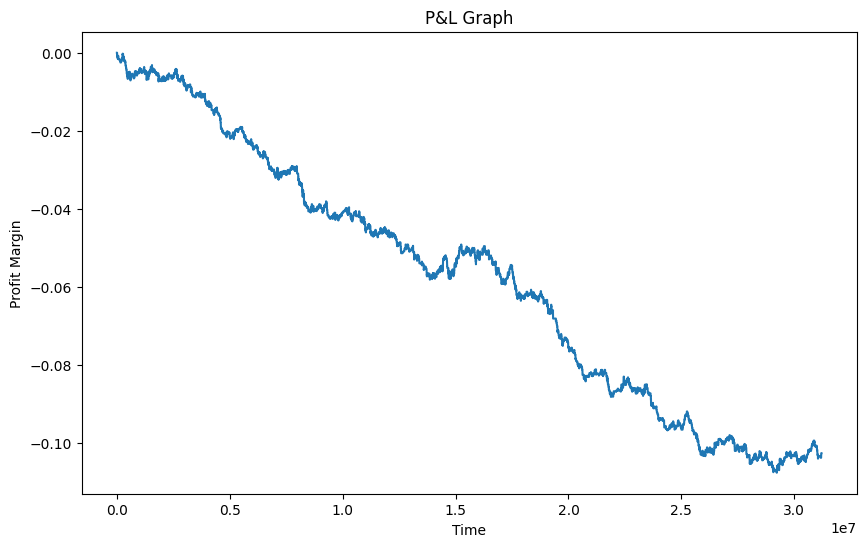

0           0.000000
300         0.000000
600         0.000000
900         0.000000
1200        0.000000
              ...   
31203000   -0.102628
31203300   -0.102628
31203600   -0.102628
31203900   -0.102628
31204200   -0.102628
Name: pl, Length: 104015, dtype: float64

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(ohlc_tick['pl'], label='pl')
plt.title('P&L Graph')
plt.xlabel('Time')
plt.ylabel('Profit Margin')
plt.show()
ohlc_tick['pl']

### Results
The above model looses 10.2% of it's starting capital. It has a Sharpe ratio of -0.23 indicating loss of capital investement. It has a max drawdown of 3.9% indicating a loss of 3.9% capital after a series of loosing trades. This model has a maximum margin requirement of 76661.6 USD.

### HFT Model using RSI for Tick Bar OHLC Data

In [39]:
# Create columns to track positions and initialize with zeros
ohlc_tick['position_rsi'] = 0
ohlc_tick['holding_rsi'] = 0
ohlc_tick['pl_rsi'] = 0
ohlc_tick['pl_rsi'] = ohlc_tick['pl_rsi'].astype(float)
ohlc_tick['daily_return_rsi'] = 0
ohlc_tick['daily_return_rsi'] = ohlc_data['daily_return_rsi'].astype(float)

# Simulate the trading strategy
for index, row in ohlc_tick.iterrows():
    i = index
    if i in ohlc_tick.index and (i-300) in ohlc_tick.index :
        # Buy condition
        if ohlc_tick['buy_signal_rsi'][i] == 1:
            # Buy at the current close price with available cash
            ohlc_tick.at[i, 'holding_rsi'] += 1
            ohlc_tick.at[i, 'position_rsi'] = 1
    
        # Sell condition
        elif ohlc_tick['sell_signal_rsi'][i] == 1:
            # Sell all holding at the current close price
            ohlc_tick.at[i, 'holding_rsi'] -= 1
            ohlc_tick.at[i, 'position_rsi'] = 0
    
        # Calculate P&L based on the change in price
        if i>300 :
            price_change = (ohlc_tick['close'][i] - ohlc_tick['close'][i-300]) / ohlc_tick['close'][i-300]
            ohlc_tick.at[i, 'pl_rsi'] = ohlc_tick['holding_rsi'][i-300] * price_change + ohlc_tick['pl_rsi'][i-300]
            ohlc_tick.at[i, 'daily_return_rsi'] = ohlc_tick['holding_rsi'][i-300] * price_change

/tmp/ipykernel_551/3060105503.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_tick['position_rsi'] = 0
/tmp/ipykernel_551/3060105503.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_tick['holding_rsi'] = 0
/tmp/ipykernel_551/3060105503.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()

In [40]:
# Calculate average daily return and standard deviation
avg_daily_return_rsi = ohlc_tick['daily_return_rsi'].mean()
std_dev_daily_return_rsi = ohlc_tick['daily_return_rsi'].std()

# Calculate annualized Sharpe ratio (assuming 252 trading days in a year)
sharpe_ratio_rsi = (avg_daily_return_rsi / std_dev_daily_return_rsi) * np.sqrt(252)
print("Sharpe Ratio:", sharpe_ratio_rsi)
# Calculate cumulative returns
ohlc_tick['cumulative_return_rsi'] = (1 + ohlc_tick['daily_return_rsi']).cumprod()

# Calculate drawdown
ohlc_tick['drawdown_rsi'] = 1 - ohlc_tick['cumulative_return_rsi'] / ohlc_tick['cumulative_return_rsi'].cummax()

# Maximum drawdown
max_drawdown_rsi = ohlc_tick['drawdown_rsi'].max()

print("Maximum Drawdown:", max_drawdown_rsi)

# Define margin factor (e.g., 2 for 2:1 leverage)
margin_factor_rsi = 2

# Calculate margin
ohlc_tick['margin_rsi'] = ohlc_tick['holding_rsi'] * ohlc_tick['close'] * margin_factor_rsi

print("Max Margin:", ohlc_tick['margin_rsi'].max())
# Display margin for each day
print("Margin for each day:")
print(ohlc_tick['margin_rsi'])

Sharpe Ratio: 0.0021757558559399315
Maximum Drawdown: 0.11805658834067523
Max Margin: 76692.2
Margin for each day:
0               0.0
300         69316.2
600        -69333.0
900        -69337.4
1200       -69362.8
             ...   
31203000        0.0
31203300        0.0
31203600        0.0
31203900        0.0
31204200        0.0
Name: margin_rsi, Length: 104015, dtype: float64


/tmp/ipykernel_551/4059790365.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_tick['cumulative_return_rsi'] = (1 + ohlc_tick['daily_return_rsi']).cumprod()
/tmp/ipykernel_551/4059790365.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_tick['drawdown_rsi'] = 1 - ohlc_tick['cumulative_return_rsi'] / ohlc_tick['cumulative_return_rsi'].cummax()
/tmp/ipykernel_551/4059790365.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

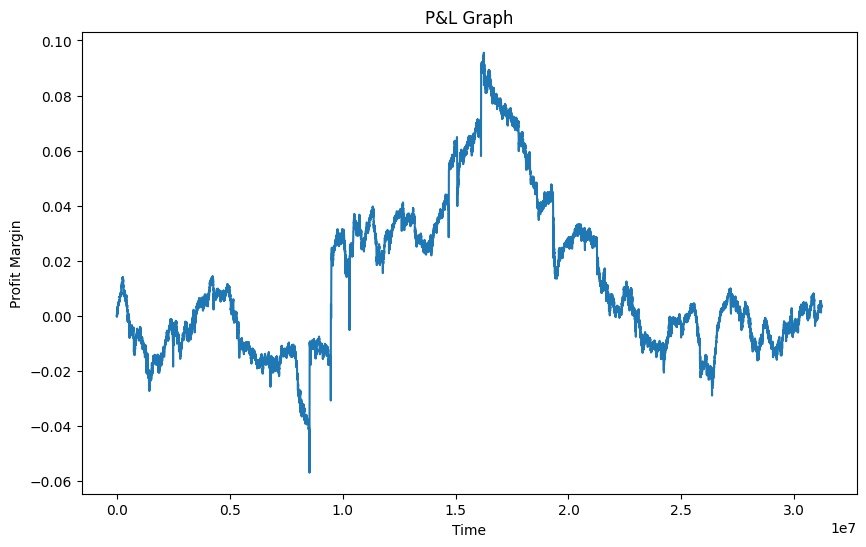

0           0.000000
300         0.000000
600         0.000242
900         0.000179
1200       -0.000187
              ...   
31203000    0.004177
31203300    0.004177
31203600    0.004177
31203900    0.004177
31204200    0.004177
Name: pl_rsi, Length: 104015, dtype: float64

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(ohlc_tick['pl_rsi'], label='pl_rsi')
plt.title('P&L Graph')
plt.xlabel('Time')
plt.ylabel('Profit Margin')
plt.show()
ohlc_tick['pl_rsi']

### Results
The above model gains 0.4% of it's starting capital. It has a Sharpe ratio of 0.02 indicating gain of capital investement. It has a max drawdown of 11.8% indicating a loss of 11.8% capital after a series of loosing trades. This model has a maximum margin requirement of 76692.2 USD.

### HFT Model SMA Crossover for Tick Bar OHLC Data

In [42]:
# Create columns to track positions and initialize with zeros
ohlc_tick['position_sma'] = 0
ohlc_tick['holding_sma'] = 0
ohlc_tick['pl_sma'] = 0
ohlc_tick['pl_sma'] = ohlc_tick['pl_sma'].astype(float)
ohlc_tick['daily_return_sma'] = 0
ohlc_tick['daily_return_sma'] = ohlc_data['daily_return_sma'].astype(float)

# Simulate the trading strategy
for index, row in ohlc_tick.iterrows():
    i = index
    if i in ohlc_tick.index and (i-300) in ohlc_tick.index :
        # Buy condition
        if ohlc_tick['buy_signal_sma'][i] == 1:
            # Buy at the current close price with available cash
            ohlc_tick.at[i, 'holding_sma'] += 1
            ohlc_tick.at[i, 'position_sma'] = 1
    
        # Sell condition
        elif ohlc_tick['sell_signal_sma'][i] == 1:
            # Sell all holding at the current close price
            ohlc_tick.at[i, 'holding_sma'] -= 1
            ohlc_tick.at[i, 'position_sma'] = 0
    
        # Calculate P&L based on the change in price
        if i>300 :
            price_change = (ohlc_tick['close'][i] - ohlc_tick['close'][i-300]) / ohlc_tick['close'][i-300]
            ohlc_tick.at[i, 'pl_sma'] = ohlc_tick['holding_sma'][i-300] * price_change + ohlc_tick['pl_sma'][i-300]
            ohlc_tick.at[i, 'daily_return_sma'] = ohlc_tick['holding_sma'][i-300] * price_change

/tmp/ipykernel_551/4026928902.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_tick['position_sma'] = 0
/tmp/ipykernel_551/4026928902.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_tick['holding_sma'] = 0
/tmp/ipykernel_551/4026928902.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()

In [43]:
# Calculate average daily return and standard deviation
avg_daily_return_sma = ohlc_tick['daily_return_sma'].mean()
std_dev_daily_return_sma = ohlc_tick['daily_return_sma'].std()

# Calculate annualized Sharpe ratio (assuming 252 trading days in a year)
sharpe_ratio_sma = (avg_daily_return_sma / std_dev_daily_return_sma) * np.sqrt(252)
print("Sharpe Ratio:", sharpe_ratio_sma)
# Calculate cumulative returns
ohlc_tick['cumulative_return_sma'] = (1 + ohlc_tick['daily_return_sma']).cumprod()

# Calculate drawdown
ohlc_tick['drawdown_sma'] = 1 - ohlc_tick['cumulative_return_sma'] / ohlc_tick['cumulative_return_sma'].cummax()

# Maximum drawdown
max_drawdown_sma = ohlc_tick['drawdown_sma'].max()

print("Maximum Drawdown:", max_drawdown_sma)

# Define margin factor (e.g., 2 for 2:1 leverage)
margin_factor_sma = 2

# Calculate margin
ohlc_tick['margin_sma'] = ohlc_tick['holding_sma'] * ohlc_tick['close'] * margin_factor_sma

print("Max Margin:", ohlc_tick['margin_sma'].max())
# Display margin for each day
print("Margin for each day:")
print(ohlc_tick['margin_sma'])

Sharpe Ratio: -0.05228957192913076
Maximum Drawdown: 0.18400285020655716
Max Margin: 77000.0
Margin for each day:
0               0.0
300             0.0
600             0.0
900             0.0
1200            0.0
             ...   
31203000    75390.8
31203300    75392.2
31203600    75395.4
31203900    75408.0
31204200    75433.6
Name: margin_sma, Length: 104015, dtype: float64


/tmp/ipykernel_551/3573462752.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_tick['cumulative_return_sma'] = (1 + ohlc_tick['daily_return_sma']).cumprod()
/tmp/ipykernel_551/3573462752.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_tick['drawdown_sma'] = 1 - ohlc_tick['cumulative_return_sma'] / ohlc_tick['cumulative_return_sma'].cummax()
/tmp/ipykernel_551/3573462752.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

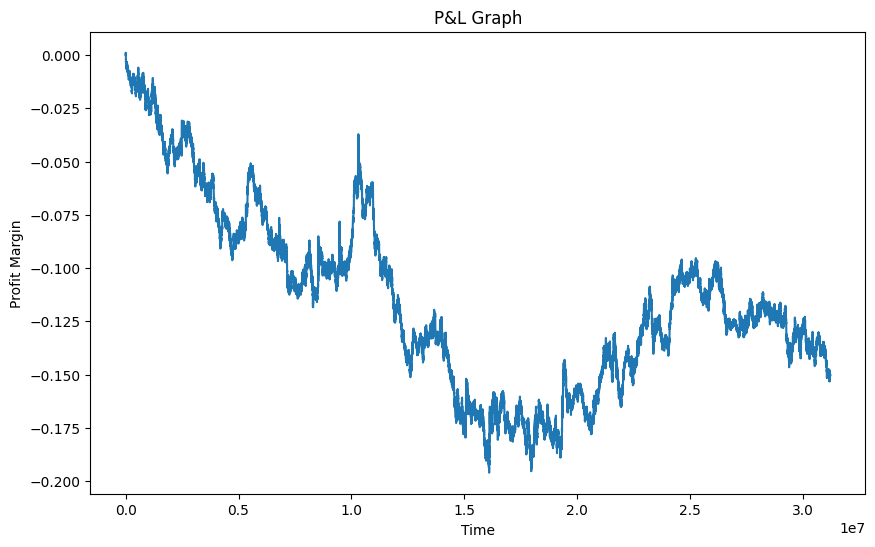

0           0.000000
300         0.000000
600         0.000000
900         0.000000
1200        0.000000
              ...   
31203000   -0.150626
31203300   -0.150607
31203600   -0.150565
31203900   -0.150398
31204200   -0.150058
Name: pl_sma, Length: 104015, dtype: float64

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(ohlc_tick['pl_sma'], label='pl_sma')
plt.title('P&L Graph')
plt.xlabel('Time')
plt.ylabel('Profit Margin')
plt.show()
ohlc_tick['pl_sma']

### Results
The above model looses -15.0% of it's starting capital. It has a Sharpe ratio of -0.05 indicating loss of capital investement. It has a max drawdown of 18.4% indicating a loss of 18.4% capital after a series of loosing trades. This model has a maximum margin requirement of 77000.0 USD.

### HFT Model using Bollinger Bands for Tick Bar OHLC Data

In [ ]:
# Create columns to track positions and initialize with zeros
ohlc_tick['position_bb'] = 0
ohlc_tick['holding_bb'] = 0
ohlc_tick['pl_bb'] = 0
ohlc_tick['pl_bb'] = ohlc_tick['pl_bb'].astype(float)
ohlc_tick['daily_return_bb'] = 0
ohlc_tick['daily_return_bb'] = ohlc_data['daily_return_bb'].astype(float)

# Simulate the trading strategy
for index, row in ohlc_tick.iterrows():
    i = index
    if i in ohlc_tick.index and (i-300) in ohlc_tick.index :
        # Buy condition
        if ohlc_tick['buy_signal_bb'][i] == 1:
            # Buy at the current close price with available cash
            ohlc_tick.at[i, 'holding_bb'] += 1
            ohlc_tick.at[i, 'position_bb'] = 1
    
        # Sell condition
        elif ohlc_tick['sell_signal_bb'][i] == 1:
            # Sell all holding at the current close price
            ohlc_tick.at[i, 'holding_bb'] -= 1
            ohlc_tick.at[i, 'position_bb'] = 0
    
        # Calculate P&L based on the change in price
        if i>300 :
            price_change = (ohlc_tick['close'][i] - ohlc_tick['close'][i-300]) / ohlc_tick['close'][i-300]
            ohlc_tick.at[i, 'pl_bb'] = ohlc_tick['holding_bb'][i-300] * price_change + ohlc_tick['pl_bb'][i-300]
            ohlc_tick.at[i, 'daily_return_bb'] = ohlc_tick['holding_bb'][i-300] * price_change

/tmp/ipykernel_551/2553259635.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_tick['position_bb'] = 0
/tmp/ipykernel_551/2553259635.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ohlc_tick['holding_bb'] = 0
/tmp/ipykernel_551/2553259635.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [ ]:
# Calculate average daily return and standard deviation
avg_daily_return_bb = ohlc_tick['daily_return_bb'].mean()
std_dev_daily_return_bb = ohlc_tick['daily_return_bb'].std()

# Calculate annualized Sharpe ratio (assuming 252 trading days in a year)
sharpe_ratio_bb = (avg_daily_return_bb / std_dev_daily_return_bb) * np.sqrt(252)
print("Sharpe Ratio:", sharpe_ratio_bb)
# Calculate cumulative returns
ohlc_tick['cumulative_return_bb'] = (1 + ohlc_tick['daily_return_bb']).cumprod()

# Calculate drawdown
ohlc_tick['drawdown_bb'] = 1 - ohlc_tick['cumulative_return_bb'] / ohlc_tick['cumulative_return_bb'].cummax()

# Maximum drawdown
max_drawdown_bb = ohlc_tick['drawdown_bb'].max()

print("Maximum Drawdown:", max_drawdown_bb)

# Define margin factor (e.g., 2 for 2:1 leverage)
margin_factor_bb = 2

# Calculate margin
ohlc_tick['margin_bb'] = ohlc_tick['holding_bb'] * ohlc_tick['close'] * margin_factor_bb

print("Max Margin:", ohlc_tick['margin_bb'].max())
# Display margin for each day
print("Margin for each day:")
print(ohlc_tick['margin_bb'])

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(ohlc_tick['pl_bb'], label='pl_bb')
plt.title('P&L Graph')
plt.xlabel('Time')
plt.ylabel('Profit Margin')
plt.show()
ohlc_tick['pl_bb']

### Results
The above model looses -50.4% of it's starting capital. It has a Sharpe ratio of -0.18 indicating loss of capital investement. It has a max drawdown of 42.2% indicating a loss of 42.2% capital after a series of loosing trades. This model has a maximum margin requirement of 76888.8 USD.